# Expose your parliament - Explainer notebook
*Group: Sam Rahbar (s183670), Jonas Mærsk (s183635) and Mikkel Goldschmidt (s183966).*

All members of the group contributed equally to the project.

## Introduction (and a crash course in Danish politics)

The aim of this report is to get insight into the Danish power structure in the national parliament "Folketinget" (often abreviated FT).
The parlament has 179 member of whom 2 are elected in Greenland and 2 on the Faroe Islands (both contries being part of The Kingdom of Denmark).
The members of parlament are often revefered to as MF (Medlem af/Member of Folketinget).

To be able to properly understand this project and the analysis, one must understand the basics of Danish politics.
As the report goes along, it will try to explain the domain knowledge, but to make the reading process easier, we have decided to write a very small crash course.
As stated in the beginning The Kingdom of Denmark has a national parliament.
The members are primarily elected through parties for a period of a maximum of 4 years.
This report will focus on an election period between 2015 and 2019 in which the Danish prime minister was Lars Løkke Rasmussen the leader of the party Venstre.
The reason for limiting ourselves to this period is that the power structure changed a lot after the election in 2019 when the new prime minister became Mette Frederiksen - the leader of Socialdemokraterne.
Denmark has a lot of parties (as opposed to contries like the US with effectively only 2 parties).
Each party will typically choose a logo and a color, that is distinct and easily recognizeable.
To refer to a party in shorthand usually a few letters are used. Unfortuneatly there is no definte standard for what is used. Sometimes a set of letters abreviating the entire party name is used. Sometimes an official letter used for the election lists are used - this is handled a little ad hoc throughout the report, since there really isn't a standard to follow.
In this period of time, the three biggest parties in Folketinget were:

- Venstre (meaning Left) - Has a *blue color*, a stylized V as logo and is commonly seen as a center-right party (yes, you read right, the party named Left is a right-leaning party). The usually use the letter 'V' as abreviation.

- Socialdemokraterne (meaning The Social Democrats) - Has a *red color*, a rose as logo and is commonly seen as s center-left party. They are usually abreviated by 'S' or 'A'.

- Dansk Folkeparti (meaning The Danish Peoples Party) - Has a *yellow color*, a logo with the letters DF encapsulated by two Danish flags and is commonly seen as a right-leaning party with focus on nationalistic values. They are usually abreviated as either 'DF' or 'O'.

Most of these parties have a youth organization - usually just named the same as the party suffixed with the word "Ungdom" (meaning youth).


## The FT Odata dataset
To gain insight into the Danish political landscape, we have used the open data provided by Folketinget about the workings of parlament.
The data is a relational database that can be found at https://oda.ft.dk/Home/OdataQuery.
It exposes information on a lot of different objects, among them:

- Members of parlament

    * Biographies introducing the background of the members
    
    * Which commities they sit on
    
    * Which party they belong to
    
    * Their roles on different commities and governmental institutions (like minesterial titles)
    
- Meetings 

    * Written transcripts from the meetings
    
    * Lists of who attended the meetings
    
The data does contain a lot more information than listed above, but these are the important points from the analysis done in this report.
Another important thing about the dataset is that it is in Danish.
This does give rise to some problems. Among these text analysis where the standard tools are defined in English. 

## Personal motivation
The reason that we chose this dataset was simply an interest in politics.
Further the idea of finding someone powerfull who wasn't in the public eye intrigued us (though throughout the project we came to realize that such conclusion required more time than we had available).
We were also motivated by the fact we hadn't seen anyone analyze this dataset before, making us feel like we had an oppertunity to actually discover something new.

## Goal for the end user
The hope was to give some level of insight into the Danish political landscape that is not portrayed by the usual media.
Where the media is very focused on qualitative data like interview and their analysis the motivations of a specific politician in a given situation, we were able to give a more qualitative look at what happens in parliament.
It is sometimes seen in the Danish media that someone uses the data provided here for stuff like counting how much a specific politician talks in parliament (usually highlighting politicians that are deemed to not participate enough in the democratic process).
We have however not seen a more quantitative analysis of language usage and how the politicians interacted with each other.
The goal was therefore to provide the end user with some insight into the political landscape using this more quantitative approach.

## Structure of the report
Even though the problem description wanted for the report to be structured with an initial look and preprocessing of the data first (section 2) and a description of the tools after (3), we decided to change the structure slightly.
The text data that we are analyzing is very loosely coupled with the network data - hence the dataset are preprocessed seperately. We therefore decided to do preprocessing and data analysis of the network data first and then do those two again afterwards for the text analysis.

## Network analysis

We have investigated to different ways of making networks from the dataset.
Only the latter is presented on the website.
The first is from a linking table linking different political actors together (defined in the section below).
The latter is from the biographies that the politicians have written about themselves.

### The predefined relations (Aktør-Aktør)

The terminology in the dataset defines an `Actor` ("Aktør" in the dataset) which is important to understand if you investigate the dataset. 
An `Actor` is some kind of political agent which can be anything from a MF to a ministerial title or the head of a commitee.
The dataset provides a linking table relating the Actors to other actors in a variety of ways (the `AktørAktør` table).
This table will be the starting point to make a network of politicians, as it provides a way to link politicians to one another.
The exact details of linking will be explained as the data is loaded and cleaned.

The `.csv` files loaded into the program is simply dumps of the entire tables from the Odata database with corrosponding names. That is the table `Aktør` corrosponds to the file `data/ft/Aktør.csv`.

#### Data cleaning

Since the data is mined from a relational database, we need to do some linking to get the information needed.
Our aim is to build a network of people (primarily politicians) and how they relate to oneanother.
Hence we will first find all Actors and then filter out those that are actual people.

In [1]:
from collections import Counter
import networkx as nx
import netwulf as nw
import pandas as pd

# The table containing all actors
actors = pd.read_csv('data/ft/Aktør.csv')
# The table describing the different types of actors that exist in the data
# This could be something equivalent to "Minister" or "Member of parlament"
actor_types = pd.read_csv('data/ft/Aktørtype.csv').set_index('id', drop=False)

# The relation table between actors
# A lot of these are links from people to subcommities like the Comitee on Health.
actor_relations = pd.read_csv('data/ft/AktørAktør.csv')
# Each of the links are tagged with a type of relation.
# This enables the distinction between for instance an Actor being the head of a comitee
# and just being a member of the comiteee.
actor_relation_types = pd.read_csv('data/ft/AktørAktørRolle.csv').set_index('id', drop=False)

To make it easier to query the data, the relations type-tables are joined onto the main table.

In [2]:
actors = actors.merge(actor_types[['type']], left_on='typeid', right_on='id')
actor_relations = actor_relations.merge(actor_relation_types[['rolle']], left_on='rolleid', right_on='id')
actors.sample(3)

,id,typeid,gruppenavnkort,navn,fornavn,efternavn,biografi,periodeid,opdateringsdato,startdato,slutdato,type
1668,286,5,NaN,Ane Halsboe-Jørgensen,Ane,Halsboe-Jørgensen,<member><url>/medlemmer/mf/a/ane-halsboe-joerg...,NaN,2021-04-07T19:20:35.493,2015-10-08T00:00:00,2016-04-27T00:00:00,Person
14852,9489,12,NaN,"Niels Jørn Schak Krog, Hjørring","Niels Jørn Schak Krog,",Hjørring,NaN,NaN,2014-09-22T14:15:45.577,NaN,NaN,Privatperson
12710,2650,12,NaN,"Benniy Dan Jensen, Rødovre","Benniy Dan Jensen,",Rødovre,NaN,NaN,2014-09-11T17:35:54.277,NaN,NaN,Privatperson


In [3]:
actor_relations.sample(3)

,id,fraaktørid,tilaktørid,startdato,slutdato,opdateringsdato,rolleid,rolle
17099,71668,14387,9987,1979-03-14T00:00:00,NaN,2015-03-19T11:02:52.277,15,medlem
93260,24935725,172,16917,2017-07-01T00:00:00,NaN,2021-04-07T19:20:53.95,15,medlem
18892,75133,14085,10410,NaN,NaN,2015-04-08T10:36:33.217,15,medlem


To get access to the party of each politician, their biography has to be read.
Here the sex of each politician can be seen as well.
Note that the biography is XML-encoded, which gives rise to the method of extraction below.

In [4]:
actors = actors.fillna('')
import re

# XML-decoding probably should be done using regex, but it works in this case
def getTag(bio,tag):
    if bio:
        results = re.search('<'+tag+'>(.*)</'+tag+'>', bio)
        if results: return results[1]
    else: return ''

actors['party'] = actors['biografi'].apply(getTag, args=('partyShortname',))
actors['køn'] = actors['biografi'].apply(getTag, args=('sex',))

The type of an Actor can be used to determine if this an actual person (which are the only Actors that we are intersted in linking).
Two types of persons are defined in the data: "Person" (which translates directly to English) and "Privatperson" (which translates to a private citizen).
Note here that by a person is meant a politician, that is registered as such in the dataset.
These people are primarily current members of parlament.

In [5]:
persons = actors[actors['type'].isin(['Person', 'Privatperson'])]
personIds = persons['id'].values

The actors in the dataset are all tagged with a `periode` (the precise definition of each is defined in the `Perioder` table of the database).
This value specified as period of time that the parlament was in session.
The need for this value comes from the fact that the actors in parlament change over time.
For instance old commities are closed and new ones opened, elections change the politicians and some politicians decide to leave their party and maybe even join a new one.
That means that a given indiviual person can be present many times in the dataset - once for each period of time.
To make sure that we get consistent view of the parlament, we choose a single period thereby making sure that each person is only represented once.

In [6]:
periods = [i for i in range(139, 148)] #period from the election in 139 to now
groups = actors[actors['periodeid'].isin(periods)]
groupIds = groups['id'].values

Looking into the data, one discovers, that almost all of the relations is from a person to some kind of group - most often commities on some subject like health, economy or transportation.

To build a network of relations we therefore extract what people that are in what commities (and other parlamentary groups).

In [7]:
# It seems to be that the `tilaktørid` always specifies the Actor id of the group
# and the `fraaktørid` always specifies the person when linking a person to a group that they are a member of. 
relations = actor_relations[(actor_relations['tilaktørid'].isin(groupIds))
                            & (actor_relations['fraaktørid'].isin(personIds))]  

These relations can then be grouped by the individual, making a list for each group of all the people that are in the group.

In [8]:
group_persons = relations[['tilaktørid','fraaktørid']]\
    .groupby(['tilaktørid'])\
    .agg(lambda tdf: tdf.unique().tolist())

all_persons_in_period = list(set(group_persons.fraaktørid.agg(sum)))

A network could then be specified by having an edge of weight 1 between all members of each group.
This approach does however yield some problems as some of the groups are very big (one of them being the entire parlament including some suppleants making a group larger than the 179 members of parlament).

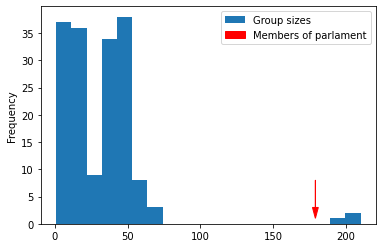

In [9]:
import matplotlib.pyplot as plt
group_persons.fraaktørid.map(len).plot(kind='hist', bins=20, label="Group sizes")
plt.arrow(x=179, y=8, dx=0, dy=-5, head_width=4, head_length=2, color="red", label="Members of parlament")
plt.legend()
plt.show()

To make investigation of the network easier, we make some subsets of the groups that can be used to investigate the group sizes.

In [10]:
medium_groups = group_persons[ group_persons.fraaktørid.map(len) < 55]
small_groups = group_persons[ group_persons.fraaktørid.map(len) < 26]
small_groups.sample(3)

,fraaktørid
tilaktørid,
16095,"[18, 366]"
17613,"[17827, 16728, 17628, 18278, 33, 15788, 199, 2..."
17612,"[86, 59, 123, 152, 112, 55, 141, 116, 191, 100]"


To make the network possible to understand, we would rather show the name of a person that the persons corrosponding id.
For that purpose, we define a mapping function from id to name.

In [11]:
actor_names = dict(zip(actors['id'], actors['navn']))
def getActorName(aid):
    return actor_names.get(aid, 'Unnamed ' + str(aid))

We then go through the groups to create links.

In [12]:
import itertools
edges = []

for personIds in medium_groups['fraaktørid']:
    combos = list(itertools.combinations(personIds, 2))
    combos_weighted = [(min(n1,n2), max(n1,n2), 1) for n1, n2 in list(combos)]
    edges.extend(combos_weighted)
    
# Unidirectional graph
edges = [(min(n1,n2), max(n1,n2), w) for (n1,n2, w) in edges]

And combine multiple edges between people into a single higher weighted edge (by adding the weights of all edges connecting them).

In [13]:
from itertools import groupby
weighted_edges = [
    (getActorName(edge[0]),
     getActorName(edge[1]),
     sum(j for n1, n2, j in data)) 
        for edge, data in groupby(edges, key=lambda v: (v[0], v[1]))
]

This enables us to define a network using almost all the groups defined in the dataset.

In [14]:
G_medium = nx.Graph()
G_medium.add_weighted_edges_from(weighted_edges)

Each party in Folketinget has a color associated with them. We color people by their party color is avaiable.

In [15]:
colorBy = 'party'
colors = {
    'S': '#a82721',
    'V': '#254264',
    'O': '#eac73e',
    'DF': '#eac73e',
    'RV': '#733280',
    'SF': '#e07ea8',
    'EL': '#e6801a',
    'KF': '#96b226',
    'NB': '#127b7f',
    'LA': '#3fb2be',
    'KD': '#8b8474',
    'ALT': '#00FF00',
    'CD': '#a70787',
    'IA': '#ff0000',
    'UFG': '#4d4d4d'
}

actorColors = { name: colors.get(colorId, 'grey') for name, colorId in actors[['navn', colorBy]].values }
nx.set_node_attributes(G_medium, actorColors, 'group')

We can then visualize the network.

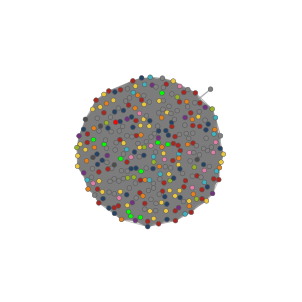

In [16]:
_ = nw.visualize(G_medium)

The theory is that this network should represent some kind of social network, as people in the same groups might know one another.
If that were the case, we would expect the degree distribution power law distributed. 
This is easy to check by plotting the data in log-log and checking if the line is linear (which it clearly is not).

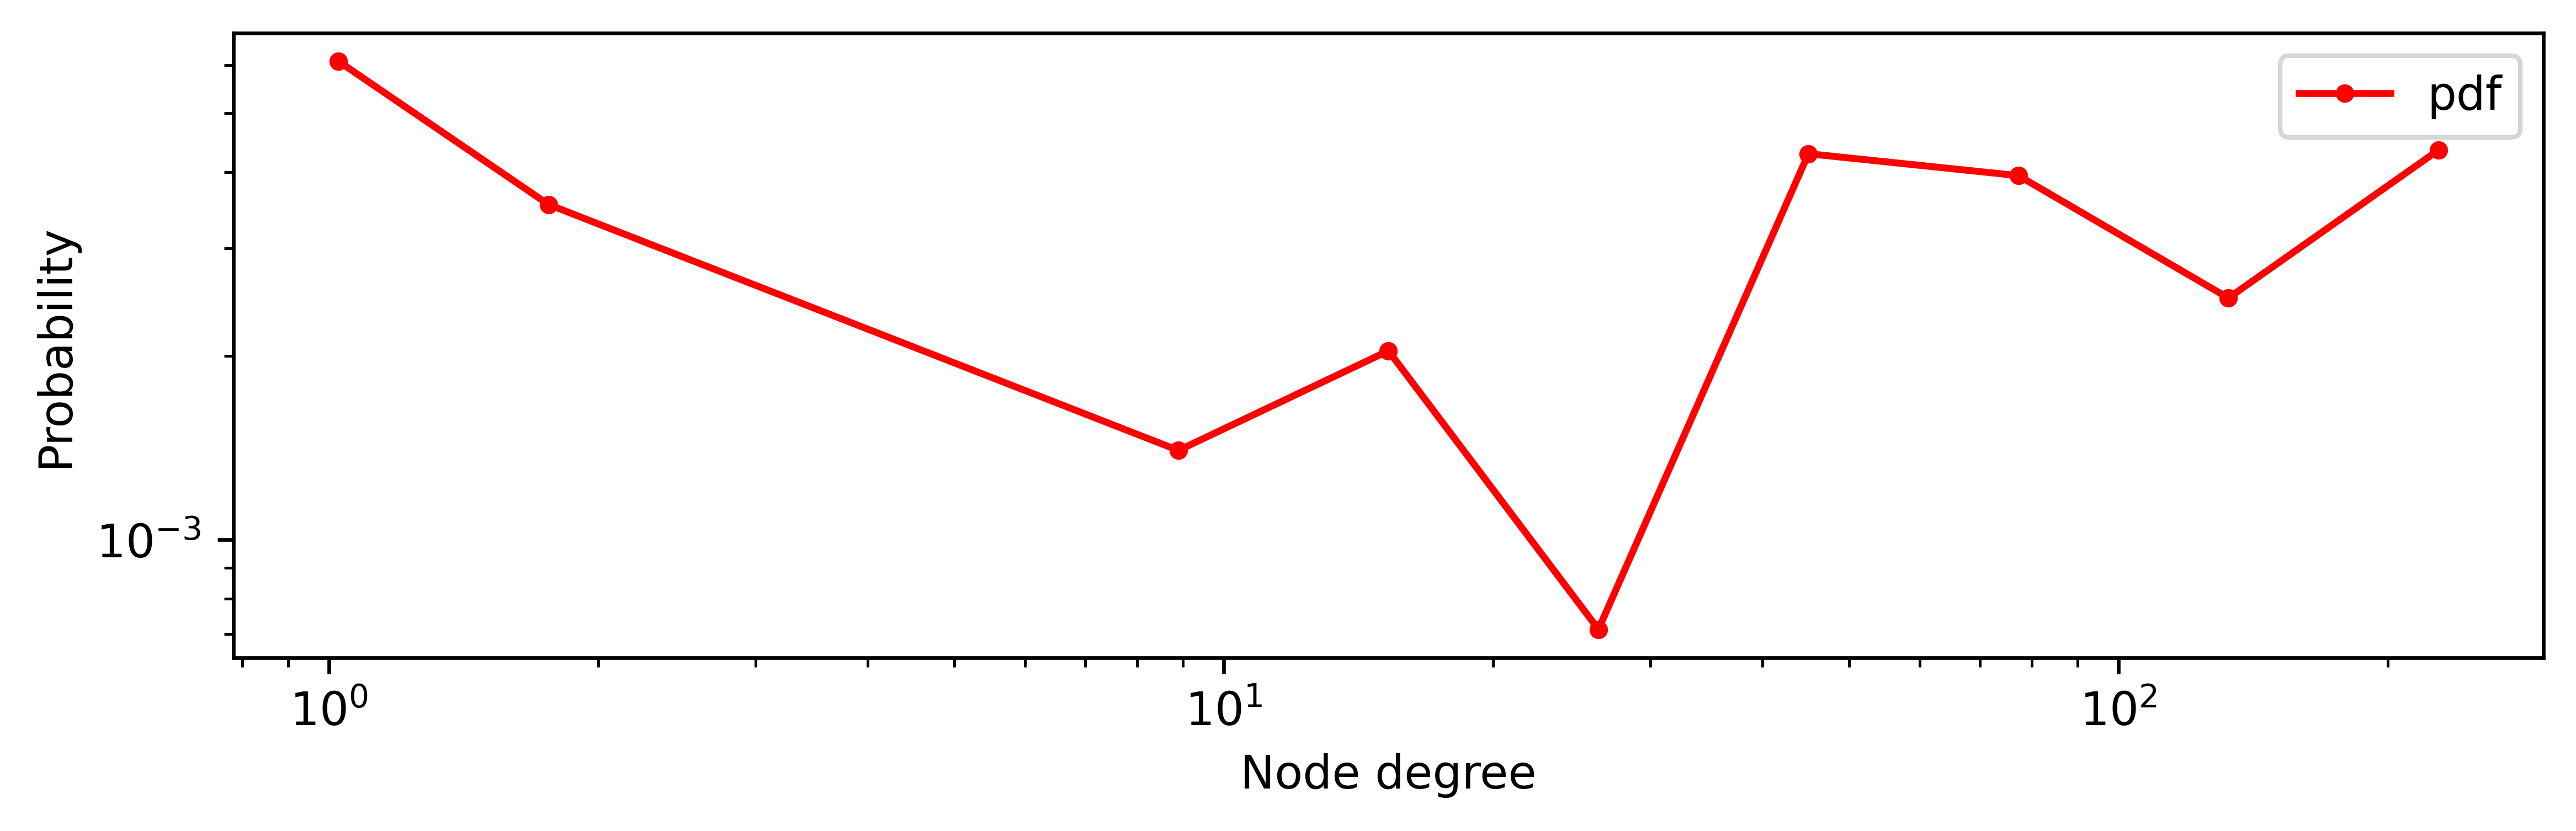

In [17]:
from custom_plots import degree_distribution_histogram

degree_distribution_histogram([v for person, v in G_medium.degree(weight='weight')])

This might be due to several different reasons, but one of them is that a group of 50 people is not certain to know each other.
To check if this might be the case, we repeat the plotting proces with all the big groups cutted off.

In [18]:
import itertools
from itertools import groupby

edges = []

for personIds in small_groups['fraaktørid']:
    combos = list(itertools.combinations(personIds, 2))
    combos_weighted = [(min(n1,n2), max(n1,n2), 1) for n1, n2 in list(combos)]
    edges.extend(combos_weighted)
    
# Unidirectional graph
edges = [(min(n1,n2), max(n1,n2), w) for (n1,n2, w) in edges]


weighted_edges = [
    (getActorName(edge[0]),
     getActorName(edge[1]),
     sum(j for n1, n2, j in data)) 
        for edge, data in groupby(edges, key=lambda v: (v[0], v[1]))
]

colorBy = 'party'

G_small = nx.Graph()
G_small.add_weighted_edges_from(weighted_edges)

actorColors = { name: colors.get(colorId, 'grey') for name, colorId in actors[['navn', colorBy]].values }
nx.set_node_attributes(G_small, actorColors, 'group')

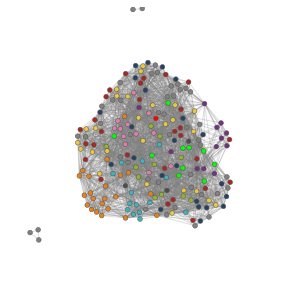

In [19]:
_ = nw.visualize(G_small)

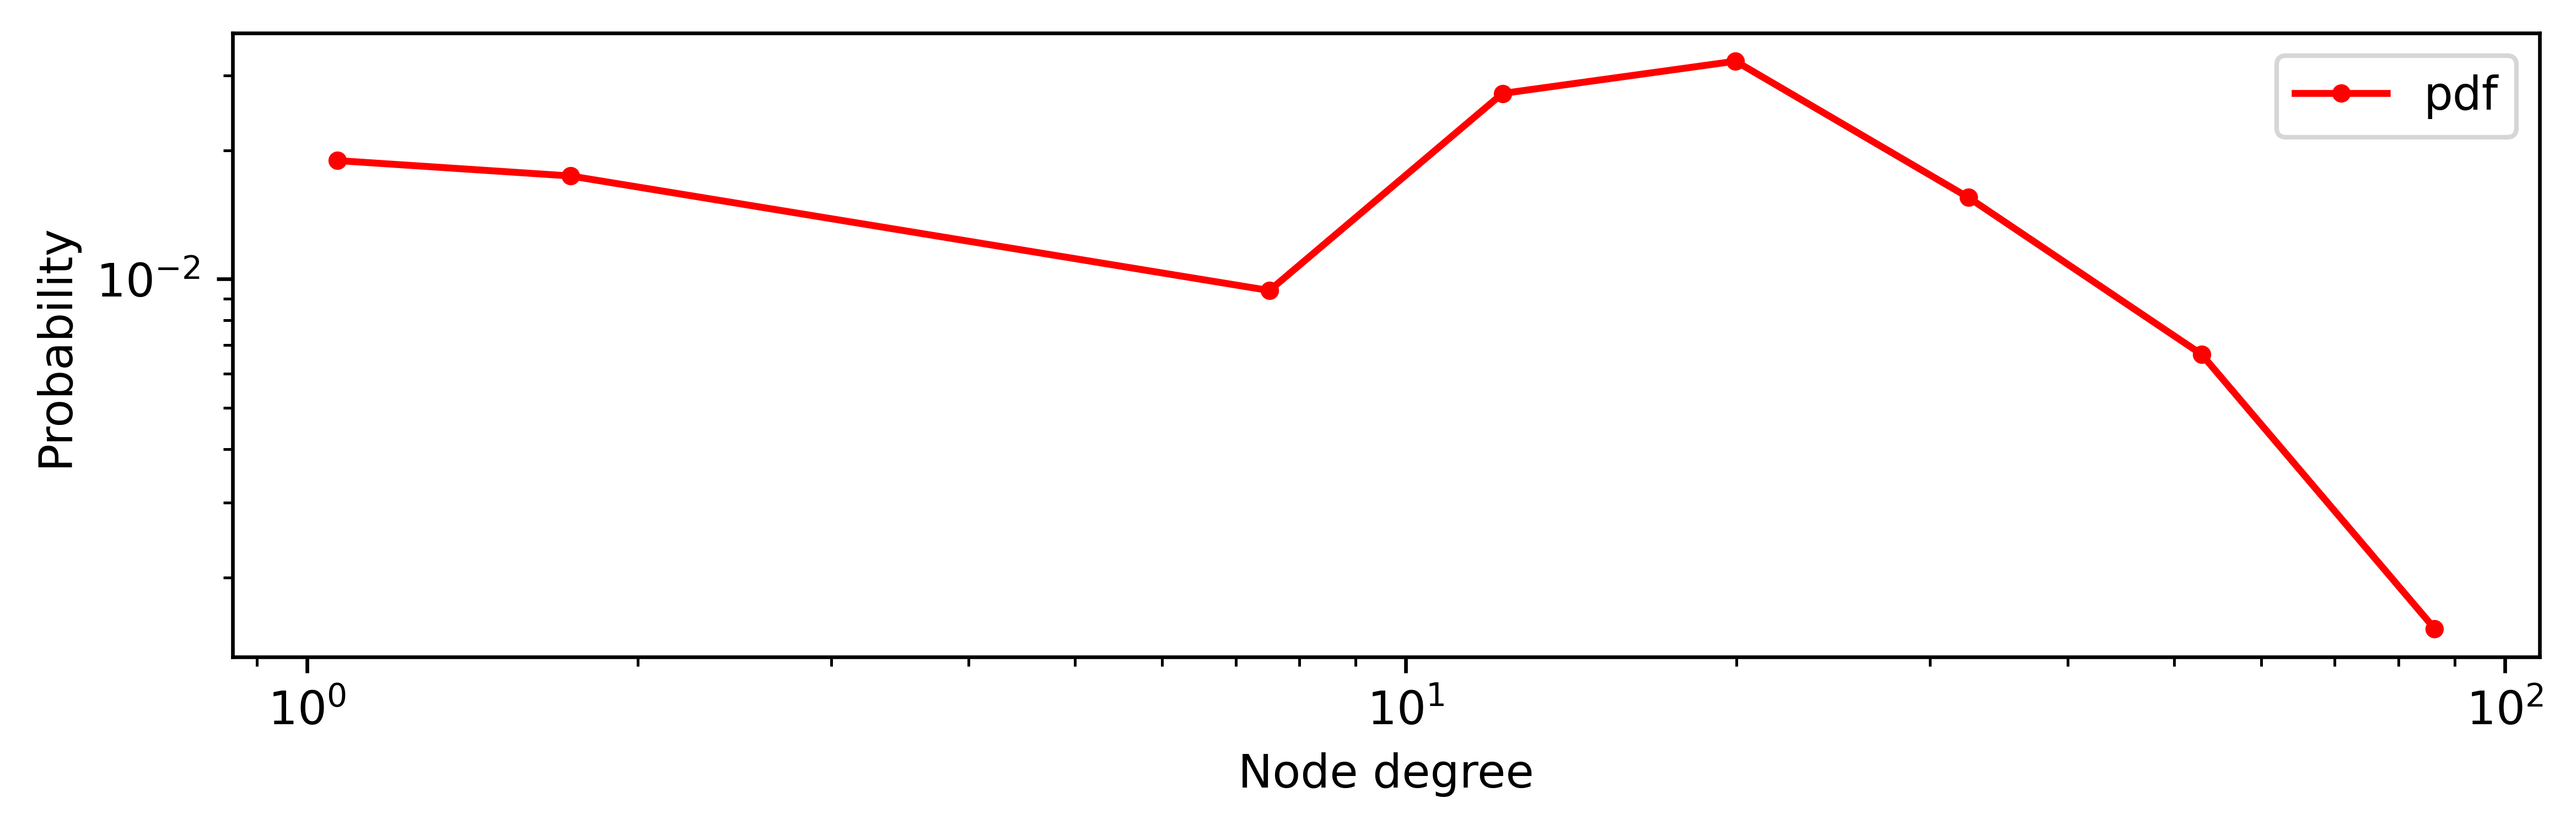

In [20]:
from custom_plots import degree_distribution_histogram

degree_distribution_histogram([v for person, v in G_small.degree(weight='weight')])

This might seem somewhat more linear at the end, but still this is not anywhere near what a normal social network distribution looks like.
We expect that this might be because the data about commities politicians work in severely lack information about anything that does not happen within the public scene in parlament.
The next section will try to connect the politicians with more insight into what they have done around parlament.

#### The work background based network

Each member of parlament has the option to write a biography - a discription of them as a person.
Most of them do this, and it is shown both in the `Aktør` table in the database and on the website of the Danish parlament www.ft.dk.

A description is an XML-encoded document with a lot of properties, where we are primarily interested in those that define what the politician has done in their career, as that might give us some insight into who they might have met and have some kind of relationship with.
The documents define 4 types of "work" that a politician has done
* `positionoftrust` - A title within a party of position of resposibility within the state
* `parliamentarypositionoftrust` - Like `positionoftrust`, but specifically within FT 
* `occupation` - Some kind of "normal" not neccesarrily political work
* `nomination` - A nomination from a party to some kind of election

We will first try to parse these biographies for relevant politicians.

In [21]:
from collections import Counter
import networkx as nx
import netwulf as nw
import pandas as pd

# Extracting the people
persons = actors[(actors['type'].isin(['Person', 'Privatperson'])) & (actors.id.isin(all_persons_in_period))]

The information we wan't about the jobs that each politician has held is:
* What their title was
* Where they worked
* When they started working there (we will limit ourselves to a year)
* When they stopped working there

As each individual politician is able to write in free text, we will need to parse this somehow.
Due to timeconstraints we need to leave some of the jobs unparsed when the politicians get particularily imaginative about the text they write in their biographies.
Fortuneatly it seems like most of these have been written by a few people (probably some secretary) as a lot of them are formatted in a similar way. 

The "parsing" below is the result of looking a lot at different examples of how the profiles were written.
We have tried to describe how each part of the code works - but to really understand the what happens one needs both a basic understanding of Danish politics and of the specifics of how the data looks.

In [22]:
import re
from bs4 import BeautifulSoup
from timeout import timeout
import os
import string

def match_year(s):
    if (r := re.fullmatch(r'(\d{4})', s)):
        return r.group(1)
    else:
        return False
    
date_range_regex = re.compile('(\d{4})-(\d{4})')
def match_year_range(s, strict=True):
    if (r := date_range_regex.fullmatch(s) if strict else date_range_regex.match(s)):
        return (r.group(1), r.group(2))
    else:
        return False


org_regex = re.compile(r'((?:[0-9a-zæøåA-ZÆØÅ/&-]+\s?)+)')

def match_organization(s):
    # The characters here has been found by trial and error
    # For instance the forward slash (/) is needed because some Danish companies
    # end their name with A/S if they are 
    pattern = r'[^\.\s0-9a-zæøåA-ZÆØÅ/&-]'
    if not re.search(pattern, s):
        return s.strip()
    else:
        return False

title_regex = re.compile(r'((?:[0-9a-zæøåA-ZÆØÅ/&-]+\s?)+)') 

def match_title(s):
    pattern = r'[^\.\s0-9a-zæøåA-ZÆØÅ\'/&-]'
    if not re.search(pattern, s):
        return s.strip()
    else:
        return False

def match_regex(s):
    r = re.search("^(.+)\s{1}(?:af|for|i|,)\s{1}(.+)\xa0(\d{4})-(\d{4})", s)
    if r:
        return {
        'organization': r.group(2),
        'title': r.group(1),
        'year_from': int(r.group(3)),
        'year_to': int(r.group(4)),
        'case_matched': 'match_regex'
    }
    return False

def comma_regex(s):
    r = re.match("^(.+)\s?,\s(.+),\xa0(\d{4})-(\d{4})", s)
    if r:
        return {
        'organization': r.group(2),
        'title': r.group(1),
        'year_from': int(r.group(3)),
        'year_to': int(r.group(4)),
        'case_matched': 'comma_regex'
    }
    return False

def current_position_regex(s):
    r = re.match("^(.+)\s(?:af|for|i)\s(.+)\xa0fra\s(\d{4})", s)
    if r:
        return {
        'organization': r.group(2),
        'title': r.group(1),
        'year_from': int(r.group(3)),
        'year_to': 2021,
        'case_matched': 'current_position_regex'
    }
    return False
    
def match_candidacy(s):
    """
        Trying to match things like
            "Kandidat for Socialdemokratiet i Åbenråkredsen 2000-2007."
        returning the party "Socialdemokratiet" and the district "Åbenråkredsen" and the period (2000, 2007).
    """
    possible_initials = [
        ("Medlem af", "Medlem"),
        ("Kandidat for", "Kandidat"),
        ("Kandidat ved", "Kandidat"),
        ("Faglig sekretær", "Faglig sekretær")
    ]
    
    title = False
    for init in possible_initials:
        if s.startswith(init[0]):
            title = init[1]
            title_text = init[0]
    if not title:
        return False

    
    stripped_first_info = s.replace(title_text, "").strip()
    
    split_words = [
        " i ",
        " for ",
        " af ",
    ]
    
    party = False
    for split_word in split_words:
        if split_word in stripped_first_info:
            try:
                party, remaining_info = stripped_first_info.split(split_word)
            except:
                return False
    
    if not party:
        return False
        
    
    
    party = party.strip()
    remaining_info.strip(" .")
    if (r := re.search(r'(\d{4})-(\d{4})', remaining_info)):
        years = (int(r.group(1)), int(r.group(2)))
        data = f"{years[0]}-{years[1]}"
    elif (r := re.search(r'(?:fra\s)?(\d{4})', remaining_info)):
        years = (int(r.group(1)), int(r.group(1)))
        data = r.group(1)
    else:
        return False
    
    district = remaining_info.replace(data, "").strip(" .")
    
    return {
        'organization': party,# + " - " + district,
        'title': title,
        'year_from': years[0],
        'year_to': years[1],
        'case_matched': 'match_candidacy'
    }



With the parsing functions defined above, we can now try to parse the work lifes of all the politicians in the period we are investigating.

In [23]:

types = ["parliamentarypositionoftrust", "occupation", "positionoftrust", "nomination"]
parsed = []
unparsed = []

for index, a in persons[~persons.biografi.isna()].iterrows():
    xml = a["biografi"]
    soup = BeautifulSoup(xml) # from_encoding seemed to be specified by the provided data being unicode
    for work_type in types:
        for obj in soup.findAll(work_type):
            add = True
            result = {
                "person_id": a.id,
                "name": a.navn,
                "work_type": work_type,
            }
            content = obj.contents[0].strip(" \t")
            splitted_comma = [ c.strip().strip(".") for c in content.split(",") ]
            splitted_nonbreakingspace = [ c.strip().strip(".") for c in content.split("\xa0") ]
            
            if len(splitted_comma) == 3 and match_title(splitted_comma[0]) and match_organization(splitted_comma[1]) and match_year_range(splitted_comma[2], strict=False):
                result["title"] = match_title(splitted_comma[0])
                result["organization"] = match_title(splitted_comma[1])
                result["year_from"] = int(match_year_range(splitted_comma[2], strict=False)[0])
                result["year_to"] = int(match_year_range(splitted_comma[2], strict=False)[1]) 
                result["case_matched"] = "3-comma"
            elif (cancidacy_match := match_candidacy(content)):
                result.update(cancidacy_match)
            elif (regex_match := match_regex(content)):
                result.update(regex_match)
            elif (comma_regex_match := comma_regex(content)):
                result.update(comma_regex_match)
            elif (current_position_match := current_position_regex(content)):
                result.update(current_position_match)
            elif len(splitted_nonbreakingspace) == 2 and match_title(splitted_nonbreakingspace[0]) and match_year_range(splitted_nonbreakingspace[1], strict=False):
                result["title"] = match_title(splitted_nonbreakingspace[0])
                result["organization"] = soup.find("party").contents[0]
                result["year_from"] = int(match_year_range(splitted_nonbreakingspace[1], strict=False)[0])
                result["year_to"] = int(match_year_range(splitted_nonbreakingspace[1], strict=False)[1]) 
                result["case_matched"] = "2-vbspace"  
            else:
                add = False
                result["content"] = obj.contents[0]
                unparsed.append(result.copy())
            if add:
                parsed.append(result.copy())

We can then check how many of the jobs that we were able to parse - and how many we weren't.

In [24]:
len(unparsed), len(parsed)

(316, 2184)

Some organizations have multiple different ways of being refered to. Especially in this dataset the political party "The Socialist Peoples Party" which in Danish is "Socialistisk Folkeparti" but is often shortened to just "SF".
This applies both to their party organization and their youth organisation.
Further a lot of them wrote very precisely what political position they held within a party - for instance one could have written "Formand for hovedbestyrelsen i sf ungdom" which would translate to "President of the main board in the Socialist Peoples Party Youth organization".
As the youth organizations are fairly small in Denmark, we have found it to be a fair assumptions, that people who have volunteered there (and later became professional politicians) probably knew each other.
We will therefor shorten any written organization containing the full string corrosponding to common fairly small Danish political group to just that group. That is in our example, the organization would be shortened to just "sf ungdom".
Further we do things like removing commas and trimming to make sure that two organizations match even if the formatting is a little weird.

In [45]:
import pandas as pd
jobs = pd.DataFrame(parsed)
jobs[jobs.case_matched == "match_regex"]

organizations = [
    "danmarks socialdemokratiske ungdom",
    "radikal ungdom",
    "venstres ungdom",
    "sf ungdom",
    "metal ungdom",
    "sfs ungdom",
    "dansk ungdoms fællesråd",
    "konservativ ungdom",
    "liberal alliances ungdom",
    "dansk folkepartis ungdom",
]

def organization_cleaner(s):
    # This special case is important to handle, as SF
    # is a major political party in Denmark
    if "socialistisk folkeparti" in s:
        s = s.replace("socialistisk folkeparti", "sf")
    for org in organizations:
        if org in s:
            # They simply couldn't decide if they had an s
            # at the end or not.. The trailing s in Danish 
            # is simply a grammatical genetive construction 
            if org == "sfs ungdom":
                return "sf ungdom"
            return org
    
    if (r := re.search(r"\(.+\)", s)):
        s = s.replace(r.group(), "")
    s = s.replace(",", "").strip() 
    
    return s

We then run the cleaner over all columns.

In [26]:
jobs["organization_original"] = jobs.organization
jobs.organization = jobs.organization.str.lower().map(organization_cleaner)

We will then define the network from the jobs that we just found.
We will link to people if they worked the same place at the same time.
The strength of the connection will be defined as the amount of years that they worked together that place.
That is, if Person A worked at Org X from 2010 to 2012 and Person B worked there from 2011 to 2017, then we will make a connection between them with weight $2$ since the worked together in 2011 and 2012 at Org X.

In [27]:
def year_overlap(years_1, years_2):
    assert years_1[0] <= years_1[1]
    assert years_2[0] <= years_2[1]
    s1, e1 = years_1
    s2, e2 = years_2
    return max(0, 1 + min(e2, e1) - max(s2, s1))

def connection_strength(job1, job2):
    if job1.person_id == job_2.person_id:
        return 0
    if job1.organization == job2.organization:
        return year_overlap( (job1.year_from, job1.year_to), (job2.year_from, job2.year_to))
    

In [28]:
from itertools import combinations

links = []


for org in list(set(jobs.organization.values)):
    to_connect = combinations([ job for index, job in jobs[ jobs.organization == org ].iterrows()], 2)
    for job_1, job_2 in to_connect:
        strength = connection_strength(job_1, job_2)
        if strength != 0:
            links.append((job_1["name"], job_2["name"], strength))


These can then be defined as a network.

In [29]:
import networkx as nx
G = nx.Graph()
G.add_weighted_edges_from(links)

In [33]:
len(G.nodes()), len(G.edges)

(207, 3044)

We then add colors based on their party.

In [30]:
colorBy = 'party'
colors = {
    'S': '#a82721',
    'V': '#254264',
    'O': '#eac73e',
    'DF': '#eac73e',
    'RV': '#733280',
    'SF': '#e07ea8',
    'EL': '#e6801a',
    'KF': '#96b226',
    'NB': '#127b7f',
    'LA': '#3fb2be',
    'KD': '#8b8474',
    'ALT': '#00FF00',
    'CD': '#a70787',
    'IA': '#ff0000',
    'UFG': '#4d4d4d'
}

actorColors = { name: colors.get(colorId, 'grey') 
                   for name, colorId 
                   in actors[['navn', colorBy]].values
              }
nx.set_node_attributes(G, actorColors, 'group')

And we can the visualize the network.

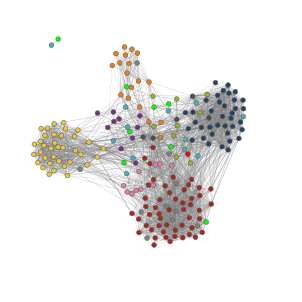

In [31]:
import netwulf
_ = netwulf.visualize(G)

It here becomes very apparent that the big parties become very tightly connected in the graph.
That really isn't a surprise, as a lot of the Danish politicians have very long political careers typically only in a single party.
This will bind them very closely with all the other politicians with the same property.

We could then try to take a look at who the most influential people are.
That is of course a very semantic question, but it is kind of like the initial question answered by Google when ranking web pages.
There they defined a web page to be important if other important websited were linking to it.
If we defined a similar metric and said someone to be well-connected if the were connected to other well-connected people, we could used the Page-Rank algorithm to apply some sort of score to measure how well placed the politician is (this algorithm i predefined in the NetworkX libary).

In [108]:
page_ranks = list(nx.algorithms.link_analysis.pagerank_alg.pagerank(G).items())
page_ranks.sort(key=lambda v: v[1], reverse=True)
page_ranks[:10]

[('Søren Espersen', 0.012987147848913128),
 ('Lars Løkke Rasmussen', 0.012219728059896693),
 ('Nick Hækkerup', 0.012068496306769946),
 ('Kristian Thulesen Dahl', 0.01153811749804906),
 ('Mette Frederiksen', 0.011006862806093481),
 ('Mogens Jensen', 0.010917006226369307),
 ('Lars Christian Lilleholt', 0.010763514592769929),
 ('Inger Støjberg', 0.010633842721172184),
 ('Peter Skaarup', 0.0102073396456307),
 ('Mogens Lykketoft', 0.00996430636679063)]

For the newcomer to the Danish politican system, these are very influential people that score well on the list.
Lars Løkke Rasmussen was the Danish prime minister at the time, Kristian Thuelsen Dahl was (and is at the time of writing) the leader of the Danish Peoples Party (the yellow one in the graph) which was the party providing the votes for Løkke to become prime minister.
Almost all the people on the list have at some point been (or are today) ministers and one of them, Mette Frederiksen, is at the time of writing the new Danish prime minister.

Using Page-Rank wasn't really neccesarry as we get a very similar result by just finding the degree of each node.

In [107]:
dgs = list(G.degree(weight='weight'))
dgs.sort(key=lambda v: v[1], reverse=True)
dgs[:10]

[('Lars Løkke Rasmussen', 213),
 ('Søren Espersen', 193),
 ('Nick Hækkerup', 190),
 ('Inger Støjberg', 178),
 ('Lars Christian Lilleholt', 177),
 ('Mette Frederiksen', 175),
 ('Kristian Jensen', 170),
 ('Kristian Thulesen Dahl', 168),
 ('Mogens Jensen', 165),
 ('Bertel Haarder', 158)]

We can then take a look into if the distribution is power law distributed.
We again plot the degree histogram in log-log.

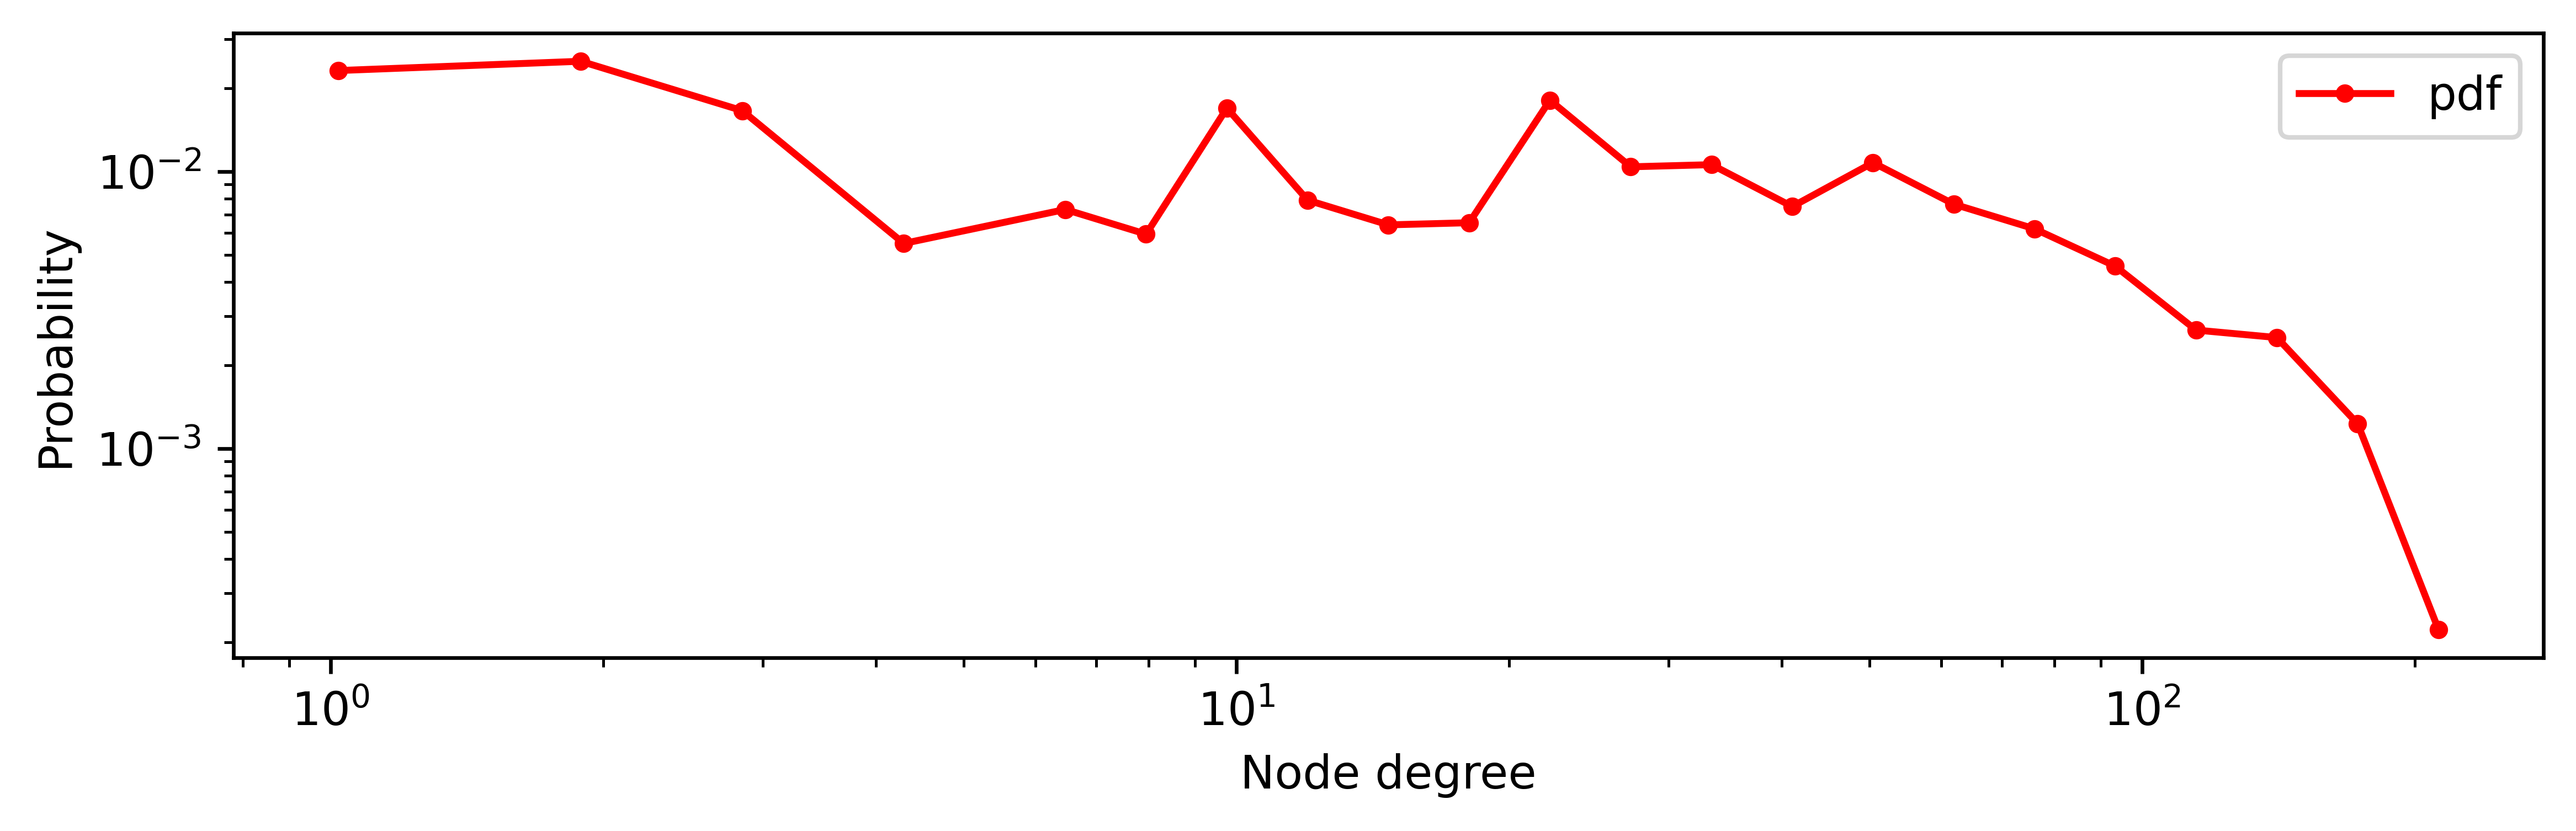

In [44]:
degree_distribution_histogram(list(dict(G.degree(weight='weight')).values()), bins=50)

The line doesn't look quite linear, but it begins to look like it at the end.
This can possibly be attributed to the fact that most people in the network are at least connected to the other people in their party - making it more unlikely for an individual to have a very low amount of connections.

#### Community detection

As we have now found a network that seems to in some way measure how well-connected people are, we can now look at how they are distributed into communities.
The hope of this exercise is to see if there were surprising communities, that could tell us something about how the people in power work.

For the purpose of community detection, we will just use the Louvain Partitioning. This choice is simply made to 

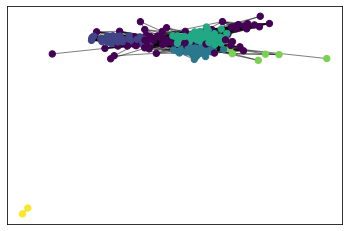

In [109]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# There is some level om randomness in this partitioning algorithm
# Hence we pin the random state to make the results repeatable.
partition = community_louvain.best_partition(G, random_state=420)
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

We need them in a another format than what the `best_partition` provides.

In [79]:
louvain_partitions = [ [person for person, group in partition.items() if group == i]
    for i in set(partition.values())
]

We can then check what modularity this partitioing gives rise to.

In [80]:
import networkx.algorithms.community.quality as nxquality

nxquality.modularity(G, louvain_partitions)

0.5515707658787116

To give some context for this we will first calculate the more natural partitioning of political parties.

In [81]:
import numpy as np
network_degree = pd.DataFrame(G.degree, columns=["name", "degree"])

party_lookup = dict(zip(persons.navn, persons.party))


party_partitions = [ [person for person in sum(louvain_partitions, start=[]) if party_lookup[person] == i]
    for i in set(party_lookup.values())
]

nxquality.modularity(G, party_partitions)

0.4475969255799385

We can then compare these two partitions further by making a confusion matrix.

In [118]:
D = np.zeros((len(louvain_partitions), len(party_partitions)))

i = 0
for c1 in louvain_partitions:
    j=0
    for c2 in party_partitions:
        overlap = len(set(c1).intersection(c2))
        D[i][j] = overlap
        j += 1 
    i += 1

Ddf = pd.DataFrame(D, columns=set(party_lookup.values()))

s = Ddf.sum()
s = s[(s.index.notnull()) & (s.index != "") & (s.values != 0)]
Ddf[s.sort_values(ascending=False).index]

,S,V,DF,EL,LA,SF,RV,KF,ALT,UFG,JF,IA
0,5.0,1.0,0.0,19.0,6.0,10.0,10.0,7.0,4.0,3.0,0.0,1.0
1,0.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,36.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
3,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Here it becomes clear that a lot of the partitions are simply primarily the political parties.
One of them though seems to be a collection of a lot of different parties (group 0).
Later we will try to investigate this group and see what is characteristic about them.

To check if these two partitions are indeed better than random (as measured by modularity), we can try to define a configuration model and check how well the same partitions work on networks.
A double-edge-swap configuration seems appropriate for this purpose.

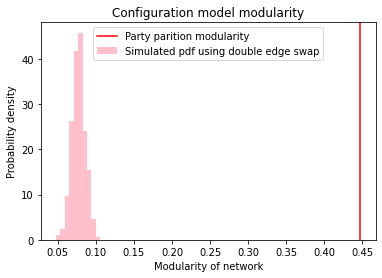

In [132]:
def shuffle_graph(G: nx.classes.graph.Graph):
    G_copy = G.copy()
    return nx.double_edge_swap(G_copy, len(G.edges), max_tries=10000)

scores = []
for i in range(300):
    G_swapped = shuffle_graph(G)
    scores.append(nxquality.modularity(G_swapped, [ c for c in party_partitions ]))
sum(scores)/len(scores)
plt.hist(scores, bins=10, density=True, color='pink', label='Simulated pdf using double edge swap')
plt.axvline(nxquality.modularity(G, party_partitions), color='r', label='Party partition modularity')
plt.ylabel("Probability density")
plt.xlabel("Modularity of network")
plt.title('Configuration model modularity')
plt.legend()
plt.show()

As expected the party partitioning is way better than random when using the double-edge-swap configuration model. 

In [134]:
# For export to the website
Ddf[s.sort_values(ascending=False).index].columns.tolist(), Ddf[s.sort_values(ascending=False).index].values.tolist()

(['S', 'V', 'DF', 'EL', 'LA', 'SF', 'RV', 'KF', 'ALT', 'UFG', 'JF', 'IA'],
 [[5.0, 1.0, 0.0, 19.0, 6.0, 10.0, 10.0, 7.0, 4.0, 3.0, 0.0, 1.0],
  [0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 36.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0],
  [51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]])

In [135]:
# Export for display on the website
import pickle
with open("louvain_partitions.pkl", "wb") as f:
    pickle.dump(louvain_partitions, f)

In [42]:
# Export for display on the website
from graph2json import graph2json
graph2json(G, 'network')

## Language Analysis

Having now analyzed how the politicians are grouped into communities, we can move on to analyzing each group.
As the topic is politics, the most important thing that the politicians are doing is speaking.
Hence we find it inherently important to analyze the language that they are using.

Since the language in the speeches are almost exclusively Danish, we needed to adapt our analysis tools for the purpose of analysing Danish texts.
Fortuneatly the sentiment analysis package Sentida (https://tidsskrift.dk/lwo/article/view/115711) is created just for this purpose.
For stopwords we are using the ones built in to `nltk` for the Danish language. Sometimes we will add some stop words such as "Hr." and "Fru" which mean "Mr." and "Mrs." respectively.
These words are extremely common in the speeches, as the language in the parliament perscribes that the members speak formally epspecially when adressing one another.

The data analyzed here are speeches from within parlament. As all speeches are transcribed and marked with who the speaker was, we have been able to analyze it without having to do a lot of manual tagging.
As with the rest of the report, we are limiting the timeframe to speeches held within the election period between 2015 and 2019.

In [136]:
# To install the sentida module
# `pip install sentida`

In [2]:
from sentida import Sentida
import re
import pandas as pd

In this notebook we limit ourselves to the first year of the election period (as this makes the code way more readable).
The data presented on out website uses all of the data from the election period.

In [3]:
votingString = "2015"
speechString = "20151"

In [4]:
meetings = pd.read_csv("data/speeches/" + speechString + ".csv")
grouped = meetings[(meetings.role == "medlem")].groupby("party")
party_docs = dict(grouped.aggregate("text").sum())
party_docs_count = dict(grouped.aggregate("meeting").count())

In [5]:
grouped_person = meetings.groupby("name")
person_docs = dict(grouped_person.aggregate("text").sum())
person_docs_count = dict(grouped_person.aggregate("meeting").count())

In Denmark people usually vote for a party rather than an individual politician within that party.
That makes it insteresting to understand what that party is actually talking about in parliament - and more importantly what makes them different from the other parties.
Further it is interesting to understand how other metrics about how they speak.
Here we have chosen to investigate the LIX-numbers for their speeches and the sentiment.

We will however also investigate each individual politician. To follow up on the former section on network analysis, we will think of the louvain partitioning as another type of party.
This might give us some insight into how these grops can be intepreted (perhaps they have a commonality that has bound their working life together, that is prevalent in the words that they use in their speeches).

### Sentiment Analysis Per Party - Sentida

This section will go into sentiment analysis on a political party by party basis.

First we define a sentiment analysis function to be used throughout the entire section on sentiment analysis.

In [6]:
def _sentiment_analysis_helper(text, output):
    return Sentida().sentida(text, output=str(output), normal = True, speed = "normal")

In [7]:
def SentAnalysis(collection, columnName: str, filename: str, party: bool, analyse: bool):
    if(analyse):
        SentAnalysis = dict([(person, _sentiment_analysis_helper(doc, "total")) for (person, doc) in collection.items()])
        pd.DataFrame(list(SentAnalysis.items()),columns = [str(columnName),'Sentiment score']).to_csv("data/AppData/" + speechString + "/"+str(filename)+".csv")
    
    person_sent_df = pd.read_csv("data/AppData/" + speechString + "/"+str(filename)+".csv", index_col = False)
    
    #By using the output of "total" each partys sentiment becomes accumulative. 
    #This way parties that speak more are typically rewarded as such. 
    #Therefore the average sentiment of each party is found below:
    
    if(party):
        meetingsPartyText = meetings.groupby(meetings["party"]).aggregate("text").sum()
        person_sent_df["Percentage sentiment"] = person_sent_df.apply(lambda row: (row["Sentiment score"]/len(meetingsPartyText[row["party"]]))*100, axis=1)
    
    if(party== False):
        meetingsPartyText = meetings.groupby(meetings["name"]).aggregate("text").sum()
        person_sent_df["Percentage sentiment"] = person_sent_df.apply(lambda row: (row["Sentiment score"]/len(meetingsPartyText[row[str(columnName)]]))*100, axis=1)
    
    person_sent_avg = dict(zip(person_sent_df[str(columnName)],person_sent_df["Percentage sentiment"]))
    person_sent = dict(zip(person_sent_df[str(columnName)],person_sent_df["Sentiment score"]))
    return(person_sent_avg, person_sent)

Analysing sentiment for each party:

In [11]:
[party_sent_avg, party_sent] = SentAnalysis(party_docs, "party", "partySent", True, True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7184.7924733564105
9816.98418920359
11673.655360098595
1081.7798095238113
275.70485978835956
3637.448697178312
5573.353110486202
4968.206200274834
10581.238756697141
5492.370928078793
594.6681777777777
362.2343121693122
62.18165343915343
7562.340034730559
Analysis done, saving...
Loading analysis...
Party


**Average sentiment of each party**

In [12]:
dict(sorted(party_sent_avg.items(), key=lambda item: item[1], reverse=True))

{'UFG': 0.6062362624466553,
 'IA': 0.4623405560002441,
 'SIU': 0.43676465283745336,
 'T': 0.37293378238596553,
 'ALT': 0.34253651555958825,
 'JF': 0.3314357874476884,
 'RV': 0.3136295814831661,
 'KF': 0.29638391830185806,
 'V': 0.27963521243779244,
 'S': 0.2676054883733499,
 'LA': 0.2618698810682469,
 'SF': 0.2574555308925206,
 'DF': 0.24408342731783503,
 'EL': 0.217731632712758}

**Total sentiment of each political party**

In [13]:
dict(sorted(party_sent.items(), key=lambda item: item[1], reverse=True))

{'EL': 11673.655360098595,
 'S': 10581.23875669714,
 'DF': 9816.98418920359,
 'V': 7562.340034730559,
 'ALT': 7184.79247335641,
 'LA': 5573.353110486202,
 'SF': 5492.3709280787925,
 'RV': 4968.206200274834,
 'KF': 3637.4486971783117,
 'IA': 1081.779809523811,
 'SIU': 594.6681777777778,
 'T': 362.2343121693122,
 'JF': 275.7048597883596,
 'UFG': 62.181653439153436}

### Sentiment Analysis Per Person - Sentida

The same sentiment analysis is done, but for every individual politician in Folketinget.

In [ ]:
[person_sent_avg, person_sent] = SentAnalysis(person_docs, "person", "personSent", True, True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1081.7798095238113
656.8498312169315
327.29735767195695
135.79622751322756
41.67362219576721
338.3614743306881
18.952199999999998
38.109582010582
89.02599206349217
337.7573201058201
3.017023809523805
1012.9513675724913
567.1573535132258
225.19033068783074
175.67103650793644
945.094861997354
157.10117106746046
103.95293650793653
761.4346534285705
699.2572931216929
7.181455026455027
1741.7137698197869
355.3946117619045
824.6077788359763
162.3049874232804
393.68878306878304
13.729576719576716
727.6611873015873
160.99596560846567
431.7516682539676
37.07246031746031
614.8048244603174
27.366269841269855
373.04711904761893
115.41019841269852
292.1935296296295
728.3800192354527
716.9013927671948
654.8289111111119
360.5897779920635
1883.8315982844053
344.9801190476187
696.8405898730173
684.9660444444436
12.63841269841271
421.59314524867756
353.9652241507939
992.499542537037
55.45617724867727
178.17100793650792
681.0235742989469
46.704576719576714
655.8272544801582
81.73535714285711
482.77461140

In [12]:
person_sent = dict([(person, SentAnal(doc, "total")) for (person, doc) in person_docs.items()])

14.805555555555564
1081.7798095238113
656.8498312169315
327.29735767195695
135.79622751322756
41.67362219576721
338.3614743306881
18.952199999999998
38.109582010582
89.02599206349217
337.7573201058201
3.017023809523805
1012.9513675724913
567.1573535132258
225.19033068783074
175.67103650793644
945.094861997354
157.10117106746046
103.95293650793653
761.4346534285705
699.2572931216929
7.181455026455027
1741.7137698197869
355.3946117619045
824.6077788359763
162.3049874232804
393.68878306878304
13.729576719576716
727.6611873015873
160.99596560846567
431.7516682539676
37.07246031746031
614.8048244603174
27.366269841269855
373.04711904761893
115.41019841269852
292.1935296296295
728.3800192354527
716.9013927671948
654.8289111111119
360.5897779920635
1883.8315982844053
344.9801190476187
696.8405898730173
684.9660444444436
12.63841269841271
421.59314524867756
353.9652241507939
992.499542537037
55.45617724867727
178.17100793650792
681.0235742989469
46.704576719576714
655.8272544801582
81.73535714

In [13]:
pd.DataFrame(list(person_sent.items()),columns = ['Person','Sentiment score']).to_csv("data/AppData/" + speechString + "/PersonSentimentTotal")

In [14]:
person_sent_df = pd.read_csv("data/AppData/" + speechString + "/PersonSentimentTotal", index_col = False)
meetingsPersonText = meetings.groupby(meetings["name"]).aggregate("text").sum()
person_sent_df["Percentage sentiment"] = person_sent_df.apply(lambda row: (row["Sentiment score"]/len(meetingsPersonText[row["Person"]]))*100, axis=1)
person_sent_avg = dict(zip(person_sent_df["Person"],person_sent_df["Percentage sentiment"]))
person_sent = dict(zip(person_sent_df["Person"],person_sent_df["Sentiment score"]))

**Average sentiment of persons in the danish parliment**

In [15]:
sorted(person_sent_avg.items(), key=lambda item: item[1], reverse=True)[:5]

{'Jan Erik Messmann': 0.8252734671700788,
 'Sisse Marie Welling': 0.6770443349753699,
 'Daniel Toft Jakobsen': 0.5550600436810947,
 'Roger Matthisen': 0.5362402039356772,
 'Lars Christian Lilleholt': 0.5246535010154891,
 'Jan Rytkjær Callesen': 0.518871691044659,
 'Malou Lunderød': 0.5106376370613269,
 'Hans Christian Thoning': 0.5027212688310545,
 'Anders Johansson': 0.48940868386934644,
 'Pia Kjærsgaard': 0.48691522598473563,
 'Thomas Jensen': 0.4852295063013064,
 'Jan Johansen': 0.4844506592109966,
 'Jens Henrik Thulesen Dahl': 0.48028237574103344,
 'Merete Dea Larsen': 0.47429347289650975,
 'Anni Matthiesen': 0.46941381194087817,
 'Nikolaj Amstrup': 0.4662083763392717,
 'Aaja Chemnitz Larsen': 0.4623405560002441,
 'Kristian Pihl Lorentzen': 0.4492500237056033,
 'Aleqa Hammond': 0.44863727287543986,
 'Ulla Tørnæs': 0.44216917137292294,
 'Annette Lind': 0.4387462030628957,
 'Ane Halsboe-Jørgensen': 0.43688796680497927,
 'Maja Panduro': 0.42967998405984525,
 'Morten Marinus': 0.418594

**Total sentiment of persons in the danish parliment**

In [16]:
sorted(person_sent.items(), key=lambda item: item[1], reverse=True)[:5]

{'Pia Kjærsgaard': 2446.505552960304,
 'Finn Sørensen': 1883.8315982844051,
 'Lisbeth Bech Poulsen': 1771.844211748423,
 'Christian Juhl': 1741.7137698197866,
 'Martin Lidegaard': 1637.8114593187854,
 'Mette Bock': 1525.218986225997,
 'Rasmus Nordqvist': 1507.2940070661386,
 'Josephine Fock': 1475.3543878511925,
 'Kristian Pihl Lorentzen': 1452.4253266402154,
 'Pelle Dragsted': 1345.1144307333318,
 'Kristian Jensen': 1296.0930402161364,
 'René Christensen': 1147.2368131851847,
 'Karsten Lauritzen': 1107.6136026904774,
 'Aaja Chemnitz Larsen': 1081.779809523811,
 'René Gade': 1081.4472940793648,
 'Benny Engelbrecht': 1012.9513675724913,
 'Henning Hyllested': 992.4995425370371,
 'Søren Egge Rasmussen': 965.3125153439166,
 'Jørn Neergaard Larsen': 958.9020920634928,
 'Brian Mikkelsen': 945.094861997354,
 'Inger Støjberg': 924.5493353359801,
 'Maria Reumert Gjerding': 915.4288347592613,
 'Karen Ellemann': 911.854452380953,
 'Mette Abildgaard': 896.7716439550244,
 'Sofie Carsten Nielsen': 8

---

### LIX analysis

[LIX](https://en.wikipedia.org/wiki/Lix_(readability_test)) is a readibility score commonly used in Scandinavia. In Danish schools this is introduced at a very early stage to determine pupils reading level. We decided to measure the speeches for each party and parliment member using LIX to try to give some insight into how complicated language they are using. 

The formula for LIX is as follows

$$
    LIX = \frac{A}{B}+\frac{C \cdot 100}{A}\\\\
$$
\begin{align}
    A:\ & Number\ of\ words\ in\ text\\
    B:\ & Number\ of\ periods\ (all\ ending\ characters\ are\ converted\ to\ periods)\\
    C:\ & Number\ of\ long\ words\ (more\ than\ 6\ letters)
\end{align}

Function for LIX is defined as a function

In [17]:
def LIX(text: str, longWordBoundary = 7):
    # replaces whitespace with space
    text = re.sub(r'\s\s+', ' ', text)
    # replaces ending characters with period ": ? ! ;"
    text = re.sub('(\:|\;|\?|\!)\w*', '.', text)
    # removes all special characters except for periods
    text = re.sub('[^0-9a-zA-Z.æøåÆØÅé ]+', '', text)
    # extracts sentences
    sentences = text.split('.')
    # removes periods
    text = re.sub('\.','',text)
    # extracts words
    words = text.split(' ')
    long_words = [w for w in words if len(w) >= longWordBoundary]
    
    lix = len(words) / len(sentences) + (len(long_words) * 100 / len(words))
  
    return lix

Find LIX for each party:

In [18]:
party_LIX = dict([(party, LIX(doc)) for (party, doc) in party_docs.items()])

In [19]:
dict(sorted(party_LIX.items(), key=lambda item: item[1], reverse=True))

{'UFG': 50.84985758849858,
 'T': 46.097804939769,
 'SIU': 45.63326029413298,
 'IA': 43.00548172488698,
 'RV': 40.520201094212894,
 'ALT': 40.25360764209356,
 'S': 39.69870616775746,
 'LA': 39.577172121364484,
 'V': 39.45486847110512,
 'EL': 38.87013834606552,
 'JF': 38.51028457149269,
 'SF': 38.25531931820791,
 'KF': 37.824341857440004,
 'DF': 37.484111161511635}

Find LIX for each parliment member

In [20]:
person_LIX = dict([(person, LIX(doc)) for (person, doc) in person_docs.items()])

In [21]:
sorted(person_LIX.items(), key=lambda item: item[1], reverse=True)[:5]

{'Hans Christian Thoning': 55.225820962663065,
 'Carsten Kudsk': 53.49299719887955,
 'Kirsten Brosbøl': 50.04360183841315,
 'Steen Holm Iversen': 49.19016453079425,
 'Jakob Sølvhøj': 48.378575575413365,
 'Carsten Bach': 48.36037226055852,
 'Daniel Toft Jakobsen': 47.090495449949444,
 'Tilde Bork': 47.0279219616968,
 'Karen Ellemann': 46.90617917118062,
 'Ellen Trane Nørby': 46.683879723002946,
 'Orla Hav': 46.20326760995481,
 'Magni Arge': 46.097804939769,
 'Aleqa Hammond': 45.9966523158828,
 'Dorthe Ullemose': 45.49625332366449,
 'Ulla Tørnæs': 45.44485774835078,
 'Emrah Tuncer': 45.22205728343836,
 'Torsten Schack Pedersen': 45.18258099801241,
 'Jørn Neergaard Larsen': 44.94186332669097,
 'Christina Egelund': 44.837193635749315,
 'Erik Christensen': 44.57682345771351,
 'Lars Christian Lilleholt': 44.4533694534525,
 'Britt Bager': 44.44452788893113,
 'Nikolaj Amstrup': 44.4052398926537,
 'Esben Lunde Larsen': 44.34370912691912,
 'Trine Bramsen': 44.11760930471553,
 'Søren Pind': 43.99

---

### Language analysis using TF-IDF

In Danish the word "politikersnak" meaning "politician speak" is a real word (https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjJvqDg_rfwAhULtKQKHe4cDPwQFjABegQIBBAD&url=https%3A%2F%2Fwww.berlingske.dk%2Fpolitik%2Fguide-til-politikersnak-udenomssnak-floskler-og-papegoejesaetninger&usg=AOvVaw0PyBFX3PVHqIF-ftjcJPLK).
It is used to refer to when a person is avoiding answering a question or is directing the conversation onto a topic that they would like to brand themself on.

To cut through all of this "politikersnak" that are in these thousands of speeches made from the podium in Folketinget, we would like to determine which words are actually special about a certain politician.
They are all using a lot of the same words, but if you for instance were interested in green energy - you would probably be interested in which politicians were actually talking about "solceller" (solar power) and "vindmøller" (wind mills). Or if you were very interested in your specific little city and there was a single politician who actually mentioned it multiple times, it would be interesting for you to know that they were actually fighting your cause from the most important podium in Denmark.
The same idea can be applied to the political parties.
The TF-IDF will hopefully also help us understand what the communities created by the Louvain Partitioning have in common.
By looking at their speeches, we will be able to see words that are important to that group.

For the purpose of finding words that are close to unique but still prevalent for some kind of document, the TF-IDF method is ideal.
In our GitHub repo we have provided a file `tf_idf.py`, that defines the exact flavour of TF-IDF we are using.


In [22]:
from tf_idf import TfIdf
from nltk.corpus import stopwords

In [23]:
def SpeechTFIDF(doc, column1: str):
    doc_counted = TfIdf(doc, stop_words=stopwords.words('danish') + ["hr", "fru", "fordi", "hen", "får"])
    doc_counted.docs_fd.keys()
    TF_IDF = pd.DataFrame()

    for p in doc_counted.docs_fd.keys():
        tfids = doc_counted.all_tf_idf(p)
        tfids_sorted = sorted(tfids, key=tfids.get, reverse=True)[:100] # Top 5

        #print(f"{p}", tfids)
        TF_IDF = TF_IDF.append([[f"{p}", tfids]],ignore_index=True)
    TF_IDF = TF_IDF.rename(columns={0: str(column1), 1:"Words"})
    return(TF_IDF)

TF_IDF is analysed for each party

In [24]:
Party_TF_IDF_ALL = SpeechTFIDF(party_docs, "Party")

In [25]:
Party_TF_IDF_ALL

,Party,Words
0,ALT,"{'tak': -0.0001620893789640562, 'hørte': 1.095..."
1,DF,"{'tak': -0.00013362092276703437, 'talen': 8.27..."
2,EL,"{'tak': -0.00013045472639642896, 'socialdemokr..."
3,IA,"{'arktis': -0.00010335540258316482, 'hot': 2.0..."
4,JF,"{'fornemt': 0.0002723333224501143, 'store': -6..."
5,KF,"{'sidder': 0.0, 'millioner': 1.904683111902463..."
6,LA,"{'retorik': 5.989939538166984e-06, 'benny': 1...."
7,RV,"{'tak': -9.589612384965261e-05, 'ordførerens':..."
8,S,"{'tak': -0.0001290966010152699, 'formand': -1...."
9,SF,"{'tak': -8.222107688316156e-05, 'gerne': -0.00..."


TF_IDF is analysed for each member

In [26]:
Person_TF_IDF_ALL = SpeechTFIDF(person_docs, "Person")

In [27]:
Person_TF_IDF_ALL.sample(5)

,Person,Words
0,,"{'punktet': 0.0061550261181423475, 'udgået': 0..."
1,Aaja Chemnitz Larsen,"{'arktis': 0.003086036992207079, 'hot': 8.3852..."
2,Aleqa Hammond,"{'tak': 8.891363930646234e-06, 'formand': 6.06..."
3,Alex Ahrendtsen,"{'lovforslag': 0.00017100373687430138, 'måske'..."
4,Anders Johansson,"{'tak': 6.979399987128776e-05, 'beslutningsfor..."
...,...,...
199,Ulla Sandbæk,"{'tak': 6.192193439774338e-05, 'undskyld': 3.4..."
200,Ulla Tørnæs,"{'gerne': 7.600299990855947e-05, 'takke': 8.91..."
201,Villum Christensen,"{'tak': 3.285573726855341e-05, 'beslutningsfor..."
202,Yildiz Akdogan,"{'tak': 8.440406916708445e-05, 'ordføreren': 0..."


---

### Member information

Connecting name and id for each Person in data

In [39]:
actors = pd.read_csv("data/ft/Aktør.csv", index_col = False)

In [40]:
ActorNameDict = dict(zip(actors["navn"], actors["id"]))

In [41]:
import re
def getTag(bio,tag):
    if bio:
        results = re.search('<'+tag+'>(.*)</'+tag+'>', bio)
        if results: return results[1]
    else: return ''

In [42]:
actor_types = pd.read_csv('data/ft/Aktørtype.csv').set_index('id', drop=False)

In [43]:
actors = actors.fillna('')
actors['parti'] = actors['biografi'].apply(getTag, args=('partyShortname',))

In [44]:
IDPartyDict = dict(zip(actors["id"],actors['biografi'].apply(getTag, args=('partyShortname',))))

---

### Combine Information

Information is combined to have profiles for each party and each member. 
This is primarily used for showing data on the website more easily.

#### Party

In [45]:
#Sentiment
PartyData = pd.DataFrame.from_dict(party_sent, orient='index')
PartyData["avgSent"] = pd.DataFrame.from_dict(party_sent_avg, orient='index')[0]
PartyData = PartyData.rename(columns={0: "totalSent",})

#LIX
PartyData["lix"] = pd.DataFrame.from_dict(party_LIX, orient='index')[0]

#TF-IDF
Party_TF_IDF_Dict = dict(zip(Party_TF_IDF_ALL["Party"],Party_TF_IDF_ALL["Words"]))
PartyData["tfIdf"] = PartyData.apply(lambda row: Party_TF_IDF_Dict[row.name], axis=1)

#Votes
PartyData["votes"] = pd.DataFrame.from_dict(PartyVotesDict, orient='index')[0]
PartyData["mandates"] = pd.DataFrame.from_dict(PartyMandatesDict, orient='index')[0]

In [46]:
PartyData

,totalSent,avgSent,lix,tfIdf,votes,mandates
ALT,7184.792473,0.342537,40.253608,"{'tak': -0.0001620893789640562, 'hørte': 1.095...",104278.0,5.0
DF,9816.984189,0.244083,37.484111,"{'tak': -0.00013362092276703437, 'talen': 8.27...",308513.0,16.0
EL,11673.655360,0.217732,38.870138,"{'tak': -0.00013045472639642896, 'socialdemokr...",245100.0,13.0
IA,1081.779810,0.462341,43.005482,"{'arktis': -0.00010335540258316482, 'hot': 2.0...",NaN,NaN
JF,275.704860,0.331436,38.510285,"{'fornemt': 0.0002723333224501143, 'store': -6...",NaN,NaN
KF,3637.448697,0.296384,37.824342,"{'sidder': 0.0, 'millioner': 1.904683111902463...",233865.0,12.0
LA,5573.353110,0.261870,39.577172,"{'retorik': 5.989939538166984e-06, 'benny': 1....",82270.0,4.0
RV,4968.206200,0.313630,40.520201,"{'tak': -9.589612384965261e-05, 'ordførerens':...",304714.0,16.0
S,10581.238757,0.267605,39.698706,"{'tak': -0.0001290966010152699, 'formand': -1....",914882.0,48.0
SF,5492.370928,0.257456,38.255319,"{'tak': -8.222107688316156e-05, 'gerne': -0.00...",272304.0,14.0


Saving Data

In [47]:
PartyData.to_csv("data/AppData/" + speechString + "/PartyData"+ speechString +".csv")

### People

###### Actor name to id dict

In [48]:
#Sentiment
PersonData = pd.DataFrame.from_dict(person_sent, orient='index')
PersonData["avgSent"] = pd.DataFrame.from_dict(person_sent_avg, orient='index')[0]
PersonData = PersonData.rename(columns={0: "totalSent",})

#LIX
PersonData["lix"] = pd.DataFrame.from_dict(person_LIX, orient='index')[0]

#TF-IDF
Person_TF_IDF_Dict = dict(zip(Person_TF_IDF_ALL["Person"],Person_TF_IDF_ALL["Words"]))
PersonData["tfIdf"] = PersonData.apply(lambda row: Person_TF_IDF_Dict[row.name], axis=1)
#PersonData["tfIdf"] = pd.DataFrame.from_dict(Person_TF_IDF_Dict, orient='index')[0]

#Votes
PersonData["votes"] = pd.DataFrame.from_dict(StemmerDict, orient='index')[0].astype(int)
PersonData["personalVotes"] = pd.DataFrame.from_dict(PStemmerDict, orient='index')[0]

#Convert index to id
PersonData["id"] = pd.DataFrame.from_dict(ActorNameDict, orient='index')[0]
PersonData["name"] = PersonData.index
PersonData = PersonData.set_index("id")

#Party
PersonData["party"] = pd.DataFrame.from_dict(IDPartyDict, orient='index')[0]

#Rearrange columns
PersonData = PersonData[["name","party", "votes", "personalVotes", "totalSent", "avgSent", "lix", "tfIdf"]]

Saving data

In [50]:
PersonData.sort_values(by="votes", ascending=False)

,name,party,votes,personalVotes,totalSent,avgSent,lix,tfIdf
id,,,,,,,,
16374.0,Anders Johansson,KF,935.0,695.000,135.796228,0.489409,42.738345,"{'tak': 6.979399987128776e-05, 'beslutningsfor..."
16074.0,Steen Holm Iversen,LA,926.0,451.000,54.123094,0.191994,49.190165,"{'tak': 6.648609365738912e-05, 'ganske': 0.000..."
77.0,Kristian Thulesen Dahl,DF,90.0,57.371,414.041959,0.317495,36.120236,"{'tak': 3.5780803764293e-05, 'socialdemokratis..."
144.0,Helle Thorning-Schmidt,S,68.0,42.412,353.965224,0.361447,30.340514,"{'ordføreren': 0.004790339002940531, 'rasmus':..."
252.0,Pia Kjærsgaard,DF,50.0,26.583,2446.505553,0.486915,33.440634,"{'udvalget': 0.000267922011908464, 'valgs': 0...."
...,...,...,...,...,...,...,...,...
15795.0,May-Britt Kattrup,LA,NaN,NaN,217.423023,0.283620,41.593239,"{'tak': 6.279490492828702e-05, 'periode': 4.99..."
NaN,Pause Pause,NaN,NaN,NaN,-10.586667,-0.333859,22.969137,"{'mødet': 0.1337599248496442, 'udsat': 0.04283..."
262.0,Sjúrður Skaale,JF,NaN,NaN,275.704860,0.331436,38.510285,"{'fornemt': 0.0011334213418015505, 'store': 0...."


In [51]:
PersonData.to_csv("data/AppData/" + speechString + "/PersonData"+ speechString +".csv")

### Export to json

In [52]:
import json

**Parties**

In [53]:
PartyData.apply(lambda row: PartyData.loc[str(row.name)].to_json('data/AppData/'+ speechString + '/party/ ' + row.name + '.json', orient="table",force_ascii=False), axis=1)

ALT    None
DF     None
EL     None
IA     None
JF     None
KF     None
LA     None
RV     None
S      None
SF     None
SIU    None
T      None
UFG    None
V      None
dtype: object

**Persons**

In [54]:
PersonDataNoNaN = PersonData[~PersonData.index.duplicated(keep='first')].dropna(how='any', thresh=6)

In [55]:
PersonDataNoNaN.apply(lambda row: PersonData.loc[int(row.name)].to_json('data/AppData/'+ speechString + '/persons/' + str(int(row.name)) + '.json', orient="table",force_ascii=False), axis=1)

id
15757.0    None
15758.0    None
18.0       None
16374.0    None
148.0      None
123.0      None
286.0      None
16503.0    None
181.0      None
168.0      None
38.0       None
120.0      None
183.0      None
129.0      None
257.0      None
83.0       None
15782.0    None
15765.0    None
15778.0    None
15779.0    None
16072.0    None
39.0       None
79.0       None
15797.0    None
15762.0    None
15773.0    None
17.0       None
270.0      None
15781.0    None
167.0      None
366.0      None
119.0      None
15798.0    None
163.0      None
16428.0    None
15766.0    None
49.0       None
261.0      None
15791.0    None
265.0      None
3975.0     None
224.0      None
164.0      None
125.0      None
179.0      None
82.0       None
144.0      None
44.0       None
3082.0     None
15800.0    None
352.0      None
28.0       None
33.0       None
4956.0     None
152.0      None
182.0      None
173.0      None
15788.0    None
207.0      None
57.0       None
15785.0    None
102.0      None
15796

---

In [49]:
pd.set_option('display.max_rows', 200)

## Discussion

In general we were able to use a lot of the tools we learned during the course. It gave us a way to actully comprehend a very large amount of information in an understandable way.
For instance the ability to know what each person was talking about gave us insights into debates that had happened with in parliament like a discussion on facial recognition where a single politician had fought very hard against it.
We were afraid that the fact that the dataset was in Danish would pose a major challenge.
However `sentida` package was awesome is something that is great to know for natively Danish *computational social scientists in the making*.

On the other hand we probably took on too big a dataset with too wide a scope for the very limited timeframe we were working with.
The notebook above is only a fraction of all the notebook that we have created.
We created a lot of different networks with a variety of spectacular bad results, and we have waited for long periods on time when analyzing speeches.
Some of the things that we didn't have the time to get into but really wanted to was:
 
 - If a party is taken out as a subgraph - could we have found communities within the parties?
 
 - How do all of these calculated statistics correlate with votes for each politician/party? (we actually began looking into this, but didn't have the time to figure out good models)
 
 - Could we have linked the politicians in better ways? Perhaps combining multiple ways of linking people.
 
 - Are there better suited community detection algorithms that we could have used?

These are just some of the questions we still feel like we haven't answered.
In general we do however feel like we learned a lot from doing the project - even if we didn't find any major conspiracy within the Danish parliament.